# Load and clean data

This notebook will exclusively deal with loading and cleaning the data for Gun Violence project.

In [55]:
# import packages
import pandas as pd
import geopandas as gpd
import contextily as ctx
import numpy as np
from census import Census
import pickle

# import custom functions
import sys
sys.path.append("/Users/justinwilliams/projects/gun-violence/src")
from general_functions import clean_cols


# filter out warnings
import warnings
warnings.filterwarnings('ignore')

# Download data

## Census data

Pull in census API key and set to variable
<br>
Grab population by state from 2020 acs 5 year estimate

In [31]:
# Set API key
c = Census(CENSUS_API, year=2020)

In [32]:
# get population by state
us_census = c.acs5.state(('NAME', 'B01003_001E'),state_fips="*")

In [33]:
# create df
us_census_df = pd.DataFrame(us_census)

# preview
us_census_df.head()

,NAME,B01003_001E,state
0,Pennsylvania,12794885.0,42
1,California,39346023.0,06
2,West Virginia,1807426.0,54
3,Utah,3151239.0,49
4,New York,19514849.0,36


In [34]:
# rename column
us_census_df.rename(columns={"NAME":"state","B01003_001E":"Population","state":"state_fips"},
                   inplace=True)

In [35]:
# clean columns
us_census_df = clean_cols(us_census_df)

In [36]:
# drop list
drop_census = ["Puerto Rico"]

# drop unecessary values
us_census_df = us_census_df[~us_census_df["state"].isin(drop_census)]

# reset index
us_census_df.reset_index().drop("index", axis=1, inplace=True)

## Shapefile

Get US Shapefile from <a href="https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.html">Census.gov</a>

In [37]:
# download shapfile
us_shp=gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_state_500k.zip")

In [38]:
# clean columns
us_shp = clean_cols(us_shp)

In [39]:
# set crs
us_shp.to_crs(4326, inplace=True)

In [40]:
# create drop list
drop_list = ["American Samoa","Guam","Commonwealth of the Northern Mariana Islands",
             "United States Virgin Islands","Puerto Rico"]

# drop uncessary territories
us_shp = us_shp[~us_shp["name"].isin(drop_list)]

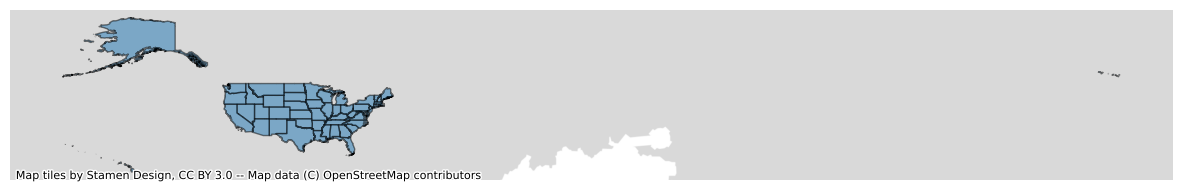

In [41]:
# add ax with .plot()
ax = us_shp.plot(figsize=(15,20), alpha=0.5, edgecolor='k')

# add basemap with contextily
# set basemap to tile to TonerLite
ctx.add_basemap(ax=ax,source=ctx.providers.Stamen.TonerLite) 

# turn off axis
ax.set_axis_off() 

In [43]:
us_shp.head()

,statefp,statens,affgeoid,geoid,stusps,name,lsad,aland,awater,geometry
0,56,01779807,0400000US56,56,WY,Wyoming,00,251458712294,1867503716,"POLYGON ((-111.05456 45.00095, -111.04507 45.0..."
1,02,01785533,0400000US02,02,AK,Alaska,00,1478942847588,245378425142,"MULTIPOLYGON (((179.48246 51.98284, 179.48657 ..."
2,24,01714934,0400000US24,24,MD,Maryland,00,25151992308,6979074857,"MULTIPOLYGON (((-76.05015 37.98691, -76.04998 ..."
4,05,00068085,0400000US05,05,AR,Arkansas,00,134660767709,3121950081,"POLYGON ((-94.61792 36.49941, -94.61765 36.499..."
5,38,01779797,0400000US38,38,ND,North Dakota,00,178694310772,4414779956,"POLYGON ((-104.04868 48.86378, -104.04865 48.8..."


### Join census and shapfile

In [44]:
# join census and shp
# drop unneeded columns
us_census_shp=gpd.GeoDataFrame(us_census_df.merge(us_shp, left_on="state",\
                                 right_on="name").drop(["statefp","name","geoid"], axis=1))

In [45]:
# preview
us_census_shp.head()

,state,population,state_fips,statens,affgeoid,stusps,lsad,aland,awater,geometry
0,Pennsylvania,12794885.0,42,01779798,0400000US42,PA,00,115881784866,3397909903,"POLYGON ((-80.51989 40.90666, -80.51963 40.911..."
1,California,39346023.0,06,01779778,0400000US06,CA,00,403671756816,20293573058,"MULTIPOLYGON (((-118.60442 33.47855, -118.5987..."
2,West Virginia,1807426.0,54,01779805,0400000US54,WV,00,62266298634,489204185,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."
3,Utah,3151239.0,49,01455989,0400000US49,UT,00,213355072799,6529973239,"POLYGON ((-114.05296 37.59278, -114.05247 37.6..."
4,New York,19514849.0,36,01779796,0400000US36,NY,00,122049142543,19257128505,"MULTIPOLYGON (((-72.03683 41.24984, -72.03496 ..."


## Gun laws

Data from <a href="https://www.statefirearmlaws.org/">State Firearm Laws</a>
<br>
This will be used to get a simple count of each states gun laws as of 2020

In [46]:
# download dataset
df_gun_laws = pd.read_excel("./data/gun_laws.xlsx")

# preview
df_gun_laws.head()

,state,year,felony,invcommitment,invoutpatient,danger,drugmisdemeanor,alctreatment,alcoholism,relinquishment,...,expartedating,dvrosurrender,dvrosurrendernoconditions,dvrosurrenderdating,expartesurrender,expartesurrendernoconditions,expartesurrenderdating,dvroremoval,stalking,lawtotal
0,Alabama,1991,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,15
1,Alabama,1992,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,16
2,Alabama,1993,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,16
3,Alabama,1994,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,16
4,Alabama,1995,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,16


I just want the state and count of gun laws, I do not need more detail then that.

In [47]:
# only need two columns, state and lawtotal
# filter by latest year
# reset index and drop old index
df_gun_laws = df_gun_laws[df_gun_laws["year"] == 2020][["state","lawtotal"]]\
.reset_index().drop("index", axis=1)

## Gun Violence data

Data will be scraped from <a href="https://www.gunviolencearchive.org/mass-shooting">Gun Violence Archive</a>
<br>
This will quantify amount of mass shootings with number killed and injured per shooting along with date and location info.

In [48]:
# import data
# have to update selenium py file to save as current date
df_gun_violence = pd.read_csv("./data/export-cfdc8ebc-e01e-4054-a000-e19841ae9e56.csv",
                parse_dates=['Incident Date'])

# clean columns
df_gun_violence = clean_cols(df_gun_violence)

# preview
df_gun_violence.head()

,incident_id,incident_date,state,city_or_county,address,#_killed,#_injured,operations
0,2478664,2022-12-11,Illinois,Chicago,5500 block of W School St,3,1,NaN
1,2478061,2022-12-09,Arizona,Phoenix,S 21st and W Burgess LN,1,3,NaN
2,2477622,2022-12-08,Michigan,Detroit,1114 Washington Blvd,0,4,NaN
3,2477404,2022-12-08,Louisiana,New Orleans,4242 Chef Menteur Hwy,0,4,NaN
4,2475554,2022-12-06,New York,Bronx,Daly Ave and E 180th St,0,4,NaN


### Missing values, shape, dtypes

In [49]:
# look at null values and shape
df_gun_violence.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   incident_id     2000 non-null   int64         
 1   incident_date   2000 non-null   datetime64[ns]
 2   state           2000 non-null   object        
 3   city_or_county  2000 non-null   object        
 4   address         1990 non-null   object        
 5   #_killed        2000 non-null   int64         
 6   #_injured       2000 non-null   int64         
 7   operations      0 non-null      float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 125.1+ KB


**Null**
<br>
Looks like some null values in the `address` column.
<br>
All `operations` column is null
<br>
<br>
**Shape**
<br>
2000 rows with 8 columns
<br>
<br>
**Dtypes**
<br>
- `incident_id`, `#_killed` and `#_injured` is int64 dtype
- `incident_date` as datetime
- `state`, `city_or_country` and `address` are object
- `operations` is float, but its all null

In [51]:
# drop operations
df_gun_violence.drop(columns="operations", inplace=True)

Datset seems pretty clean, need to scan it for odd erroneous values that will most likely come to light in visual EDA.

## Save datasets

In [56]:
# pickle datasets
df_gun_violence.to_pickle('./data/pickle/df_gun_violence')
df_gun_laws.to_pickle('./data/pickle/df_gun_laws')
us_census_df.to_pickle('./data/pickle/df_us_census')
us_shp.to_file("./data/shp/us_shp")
us_shp.to_pickle("./data/pickle/us_shp")
us_census_shp.to_file("./data/shp/us_census_shp")
us_census_shp.to_pickle('./data/pickle/us_census_shp')